In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

#Milestone-2


##Setup and Initialization


In [3]:
# Install the Kaggle package
!pip install kaggle

import os
import json

# Move the kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify if the API is configured correctly
!kaggle datasets list

# Download the Sentiment140 dataset
!kaggle datasets download -d kazanova/sentiment140

# Unzip the dataset
!unzip sentiment140.zip -d sentiment140

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 98% 79.0M/80.9M [00:05<00:00, 15.5MB/s]
100% 80.9M/80.9M [00:05<00:00, 14.2MB/s]
Archive:  sentiment140.zip
  inflating: sentiment140/training.1600000.processed.noemoticon.csv  


In [4]:
# Load the dataset into a pandas DataFrame
file_path = 'sentiment140/training.1600000.processed.noemoticon.csv'
DATA_COL = ['score', 'id', 'date', 'flag', 'user', 'text']

#Read File
data = pd.read_csv(file_path, names=DATA_COL, encoding='latin-1')

##Data Exploration

In [5]:
#Display head of data
data.head()

,score,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#Prints attributes of dataset
print('Length of Data is: ', len(data))
print('Shape of Data is: ', data.shape)

Length of Data is:  1600000
Shape of Data is:  (1600000, 6)


In [7]:
#Prints data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   score   1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
#Check for missing values
missing_values = data.isnull().sum()
print(missing_values)
#Check for Null Values
null_values = (data.isnull()).sum()
print(null_values)

score    0
id       0
date     0
flag     0
user     0
text     0
dtype: int64
score    0
id       0
date     0
flag     0
user     0
text     0
dtype: int64


In [9]:
#Count Scores
data['score'].value_counts()

,count
score,
0,800000
4,800000


##Plotting Data


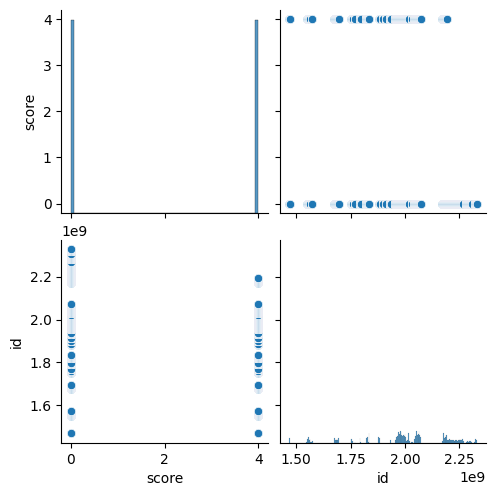

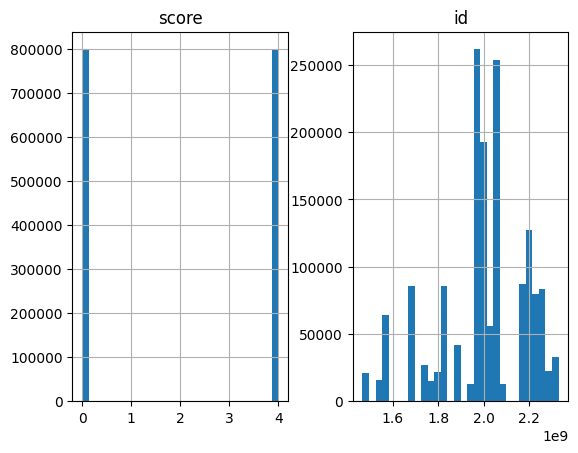

In [10]:
#pairplot
sns.pairplot(data)
plt.show()

#plot distributions
data.hist(bins=30)
plt.show()

#Milestone-3


##Preprocessing Data

In [11]:
#Further Set up Data
data = data[['text', 'score']]

# Cleaning the Data
text = data[['text']]
score = data[['score']]

pos_score = data[data['score'] > 0]
neg_score = data[data['score'] < 0]

dataset = pd.concat([pos_score, neg_score])

stopwords = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves",
    "you", "your", "yours", "yourself", "yourselves", "he", "him",
    "his", "himself", "she", "her", "hers", "herself", "it",
    "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those",
    "am", "is", "are", "was", "were", "be", "been", "being", "have",
    "has", "had", "having", "do", "does", "did", "doing", "a", "an",
    "the", "and", "but", "if", "or", "because", "as", "until", "while",
    "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from",
    "up", "down", "in", "out", "on", "off", "over", "under", "again",
    "further", "then", "once", "here", "there", "when", "where", "why",
    "how", "all", "any", "both", "each", "few", "more", "most", "other",
    "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
    "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"
    ]

###Clean Data Function

In [12]:
def clean_data(text):
  text = text.str.lower()
  # Convert to lowercase
  text = text.str.lower()
  #Remove Usernames
  text = text.apply(lambda x: re.sub(r'@\w+', '', x))
  # Remove special characters and numbers
  text = text.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
  # Remove extra spaces
  text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
  # Remove stopwords
  text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
  return text

###Finalize Preprocessing

In [15]:
# Apply the cleaning function to the 'text' column
data['text'] = clean_data(data['text'])
X = data['text']
y = data['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the cleaned text
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Scale the features
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

# Encode the target variable
y = data['score']

###Finalized Data Information

In [16]:
# Display the shape
print('Training data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (1280000, 5000)
Test data shape: (320000, 5000)
Training labels shape: (1280000,)
Test labels shape: (320000,)


##Train First Model

In [17]:
# Create a logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

##Training vs. Test Error

In [18]:
#Comparing Accuracy Scores
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

#Comparing Classification Reports
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

#Comparing Confusion Matrixes
print("Train Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.77697890625
Test Accuracy: 0.77406875
Train Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    640506
           4       0.77      0.80      0.78    639494

    accuracy                           0.78   1280000
   macro avg       0.78      0.78      0.78   1280000
weighted avg       0.78      0.78      0.78   1280000

Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           4       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

Train Confusion Matrix:
[[483897 156609]
 [128858 510636]]
Test Confusion Matrix:
[[119968  39526]
 [ 32772 127734]]


# Milestone 4


##Train Second Model

In [ ]:
#Initialize and Train
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

#Prediction
y_train_pred_svm = svm_model.predict(X_train)
y_test_pred_svm = svm_model.predict(X_test)

#Accuracy
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)

##Training vs. Test Error 2

In [95]:
#Comparison Print
print("SVM Train Accuracy:", train_accuracy_svm)
print("SVM Test Accuracy:", test_accuracy_svm)

print("SVM Train Classification Report:")
print(classification_report(y_train, y_train_pred_svm))
print("SVM Test Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

print("SVM Train Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_svm))
print("SVM Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_svm))

SVM Train Accuracy: 1.0
SVM Test Accuracy: 0.625
SVM Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           4       1.00      1.00      1.00        80

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159

SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.48      0.57        21
           4       0.58      0.79      0.67        19

    accuracy                           0.62        40
   macro avg       0.65      0.63      0.62        40
weighted avg       0.65      0.62      0.62        40

SVM Train Confusion Matrix:
[[79  0]
 [ 0 80]]
SVM Test Confusion Matrix:
[[10 11]
 [ 4 15]]
